In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deathtrooper/multichannel-glaucoma-benchmark-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/glucoam/.cache/kagglehub/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/versions/10


In [8]:
import pandas as pd

import os

In [9]:
os.listdir(path)

['optic-cup',
 'spectral-oct-cup',
 'metadata - standardized.csv',
 'vessel-artery',
 'spectral-oct',
 'spectral-oct-disc',
 'full-fundus',
 'optic-disc',
 'blood-vessel',
 'vessel-vein']

In [10]:
df = pd.read_csv(f"{path}/metadata - standardized.csv")

In [11]:
import cv2

In [15]:
from utils.main import check_file

In [16]:
images = []
mask = []

IMG_SIZE = 256

for item in df['names']:
    if not check_file(f"./data/normal/full-fundus/{item}.png"):
        continue
    
    img = cv2.imread(f"./data/normal/full-fundus/{item}.png")
    r_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    mask_img = cv2.imread(f"./data/normal/optic-disc/{item}.png")
    r_mask_img = cv2.resize(mask_img, (IMG_SIZE, IMG_SIZE))

    images.append(r_img)
    mask.append(r_mask_img)

In [17]:
print("Size of Images : ", len(images))
print("Size of Optic cup : ", len(mask))

Size of Images :  3103
Size of Optic cup :  3103


In [18]:
import numpy as np

In [19]:
images = np.array(images)
mask = np.array(mask)

In [20]:
e_images = np.expand_dims(images, axis=-1)
e_mask = np.expand_dims(mask, axis=-1)

In [21]:
normalize_images = e_images.astype("float32") / 255.0
noramalize_mask = e_mask.astype("float32") / 255.0

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(normalize_images, noramalize_mask, train_size=0.01)

In [24]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [25]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [26]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [68]:
model = sm.Unet(
    backbone_name="resnet34",
    encoder_weights="imagenet",
    classes=1,
    activation="sigmoid"
)

In [69]:
loss = sm.losses.DiceLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"]

In [70]:
import tensorflow as tf

In [71]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss,
    metrics=metrics
)

In [72]:
history = model.fit(
    X_train, Y_train,
    batch_size=4,
    epochs=100,
    validation_split=0.1
)

Epoch 1/100


2025-11-19 15:04:29.019889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


7/7 [==============================] - 8s 370ms/step - loss: 0.9496 - iou_score: 0.0326 - f1-score: 0.0627 - accuracy: 0.5638 - val_loss: 0.9586 - val_iou_score: 0.0215 - val_f1-score: 0.0420 - val_accuracy: 0.0255
Epoch 2/100
7/7 [==============================] - 1s 152ms/step - loss: 0.9236 - iou_score: 0.0642 - f1-score: 0.1200 - accuracy: 0.6840 - val_loss: 0.9570 - val_iou_score: 0.0215 - val_f1-score: 0.0421 - val_accuracy: 0.0277
Epoch 3/100
7/7 [==============================] - 1s 149ms/step - loss: 0.9140 - iou_score: 0.0860 - f1-score: 0.1580 - accuracy: 0.7723 - val_loss: 0.9565 - val_iou_score: 0.0219 - val_f1-score: 0.0429 - val_accuracy: 0.0461
Epoch 4/100
7/7 [==============================] - 1s 149ms/step - loss: 0.9085 - iou_score: 0.1103 - f1-score: 0.1981 - accuracy: 0.8289 - val_loss: 0.9554 - val_iou_score: 0.0254 - val_f1-score: 0.0495 - val_accuracy: 0.1787
Epoch 5/100
7/7 [==============================] - 1s 149ms/step - loss: 0.9038 - iou_score: 0.1299 - f1

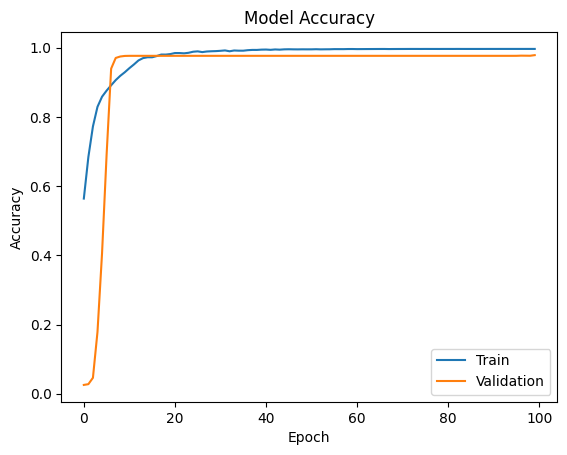

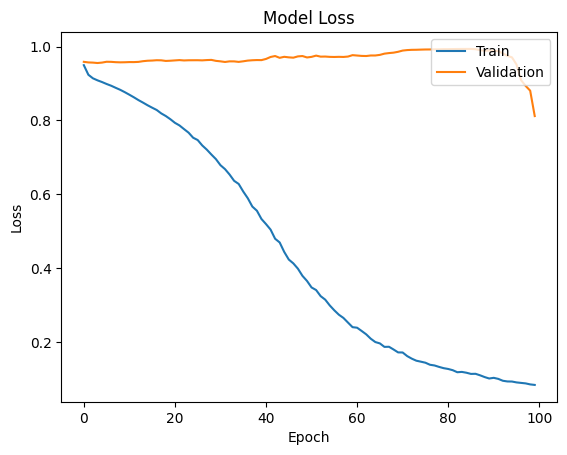

In [73]:
import matplotlib.pyplot as plt

# Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Loss Graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [74]:
model.save("./dist/u_net_main_mask.keras")
model.save_weights("./dist/u_net_main_mask.weights.h5")

In [75]:
test_img = cv2.imread(f"{path}/full-fundus/full-fundus/EyePACS-Glaucoma-2688.png")
test_img = cv2.resize(test_img, (IMG_SIZE, IMG_SIZE))
test_img_list = []

test_img_list.append(test_img)

In [76]:
test_img_list = np.array(test_img_list)

In [77]:
test_img_list = test_img_list.astype("float32") / 255.0

In [78]:
test_img_list.shape

test_img_list = np.expand_dims(test_img_list, axis=0)

In [79]:
test_img_list.shape

(1, 1, 256, 256, 3)

In [80]:
mask = model.predict(test_img_list[0])

1/1 [==============================] - 1s 567ms/step


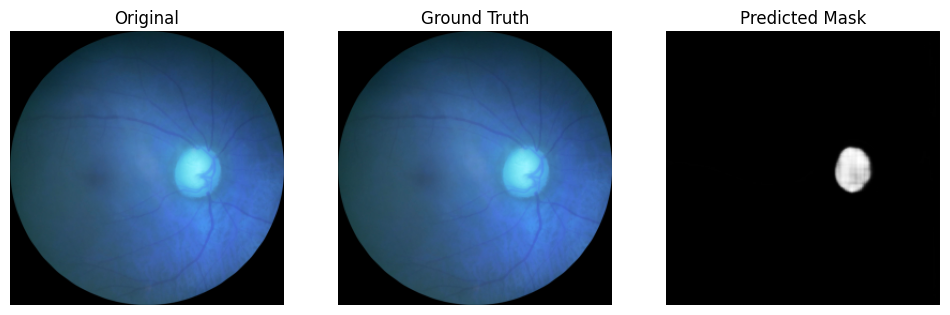

In [81]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(test_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(test_img)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(mask[0].squeeze(), cmap="gray")
plt.axis("off")

plt.show()